In [1]:
import os
import sys

import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
from models.TrainPlanningOperator2D import PlanningOperator2D
from heuristics import generaterandompos
from heuristics import euclideannorm, FMM, dijkstra, planningoperator, scikitFMM, highresFMM
from heuristics import testheuristiconmaps, testheuristiconmaps_eplan

from astar.astar import  AStar
from astar.environment_simple import Environment2D
from astar.utilities import tic,toc,drawMap,drawPath2D,plotClosedNodes,plotInconsistentNodes



Load Test Maps

In [2]:
Ntotal = 550
ntest = 50
sub = 1
Sx = Sy = int(((256 - 1) / sub) + 1)
maps = np.load('dataset/street_maps_256x256_dijkstra/mask.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

mapx = maps[10,:,:].reshape(1,256,256)
goalx = generaterandompos(mapx)
startx = generaterandompos(mapx)

map = 1-np.squeeze(mapx,axis=0)
goal = np.squeeze(goalx,axis=0)
start = np.squeeze(startx,axis=0)

start = np.array([248,177])
goal = np.array([151,239])


In [3]:
modes = 12
width = 32
nlayers = 5

model = PlanningOperator2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load("trained_models/modeldijkstra256.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

valuefunction_po,_ = planningoperator(map,goal,model=model,erosion=2)
valuefunction_ecldn,_ = euclideannorm(map,goal)


In [4]:
env = Environment2D(goal, map, 1.5*valuefunction_ecldn)
path_cost_po, path_po, action_idx_po, nodes_count_po, sss_po = AStar.xplan(start, env)

env1 = Environment2D(goal, map, valuefunction_ecldn)
path_cost_po_1, path_po_1, action_idx_po_1, nodes_count_po_1, sss_po_1 = AStar.repairPlan(start, env1, sss_po)

path_array = np.asarray(path_po)
f, ax = plt.subplots()
drawMap(ax, map)
plotClosedNodes(ax,sss_po)
plotInconsistentNodes(ax,sss_po,env)
drawPath2D(ax, path_array)
print("Path Cost:" ,path_cost_po,
      "\n#Nodes Expanded:",nodes_count_po)

Size of sss['pq'] 1:  244
Size of sss['pq'] 2:  317
Size of sss['pq'] 3:  317


UnboundLocalError: local variable 'curr' referenced before assignment

ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (0,).

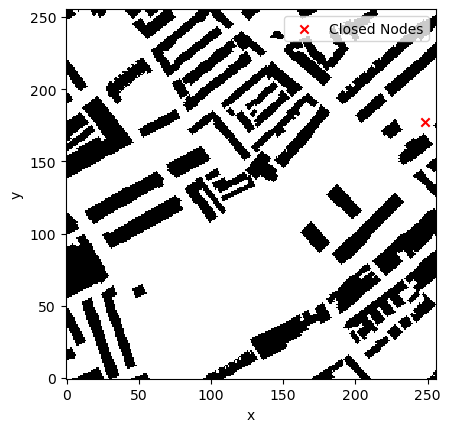

In [ ]:
path_array_1 = np.asarray(path_po_1)
f, ax = plt.subplots()
drawMap(ax, map)
plotClosedNodes(ax,sss_po_1)
plotInconsistentNodes(ax,sss_po_1,env1)
drawPath2D(ax, path_array_1)
print("Path Cost:" ,path_cost_po_1,
      "\n#Nodes Expanded:",nodes_count_po_1)

Path Cost: 135.02438661763935 
#Nodes Expanded: 2690


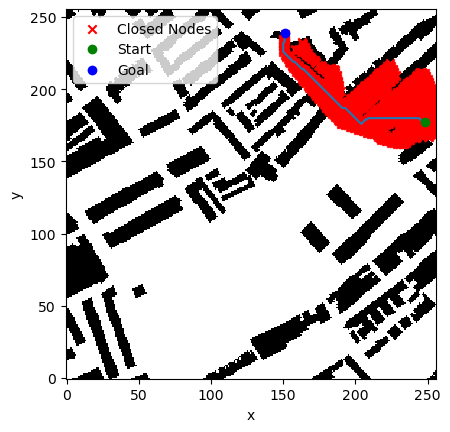

In [ ]:
valuefunction_ecldn,_ = euclideannorm(map,goal)
env = Environment2D(goal, map, valuefunction_ecldn)
path_cost, path, action_idx, nodes_count, sss = AStar.plan(start, env)
path_array = np.asarray(path)
f, ax = plt.subplots()
drawMap(ax, map)
plotClosedNodes(ax,sss)
plotInconsistentNodes(ax,sss,env)
drawPath2D(ax, path_array)
print("Path Cost:" ,path_cost,
      "\n#Nodes Expanded:",nodes_count)